# population-inference
notebook for running vectorised inference over a population of hares or emus

In [1]:
#stock imports
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import pickle
import scipy
import os
##plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import corner

#script imports
from scripts import prior_funcs, utils

from scripts.pitchfuncs_ultra_pca import emulator
from scripts.pitchfuncs_ultra_pca import ultra_ns_vector_nice

os.environ["CUDA_VISIBLE_DEVICES"]="0"

physical_devices = tf.config.list_physical_devices("GPU") 

tf.config.experimental.set_memory_growth(physical_devices[0], True)

gpu0usage = tf.config.experimental.get_memory_info("GPU:0")["current"]

print("Current GPU usage:\n"
     + " - GPU0: " + str(gpu0usage) + "B\n")


2024-06-17 17:09:46.173838: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-17 17:09:46.173865: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-17 17:09:46.174875: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-17 17:09:46.179969: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-17 17:09:46.691608: W tensorflow/compiler/tf2

Current GPU usage:
 - GPU0: 0B



2024-06-17 17:09:48.263090: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 17749 MB memory:  -> device: 0, name: NVIDIA RTX A4500, pci bus id: 0000:41:00.0, compute capability: 8.6


## import neural network

In [2]:
pitchfork_name = "nu6-40_elu_nonorm_feh"
pitchfork = emulator(pitchfork_name)

with open("pitchfork/" +pitchfork_name+ ".pkl", 'rb') as fp:
     pitchfork_info = pickle.load(fp)

pitchfork_ranges = pitchfork_info['parameter_ranges']

initial_mass range: [min = 0.8, max = 1.2]
initial_Zinit range: [min = 0.003869061466818601, max = 0.0389797119014747]
initial_Yinit range: [min = 0.24, max = 0.32]
initial_MLT range: [min = 1.7, max = 2.5]
star_age range: [min = 0.029664111540787196, max = 13.999973871651315]


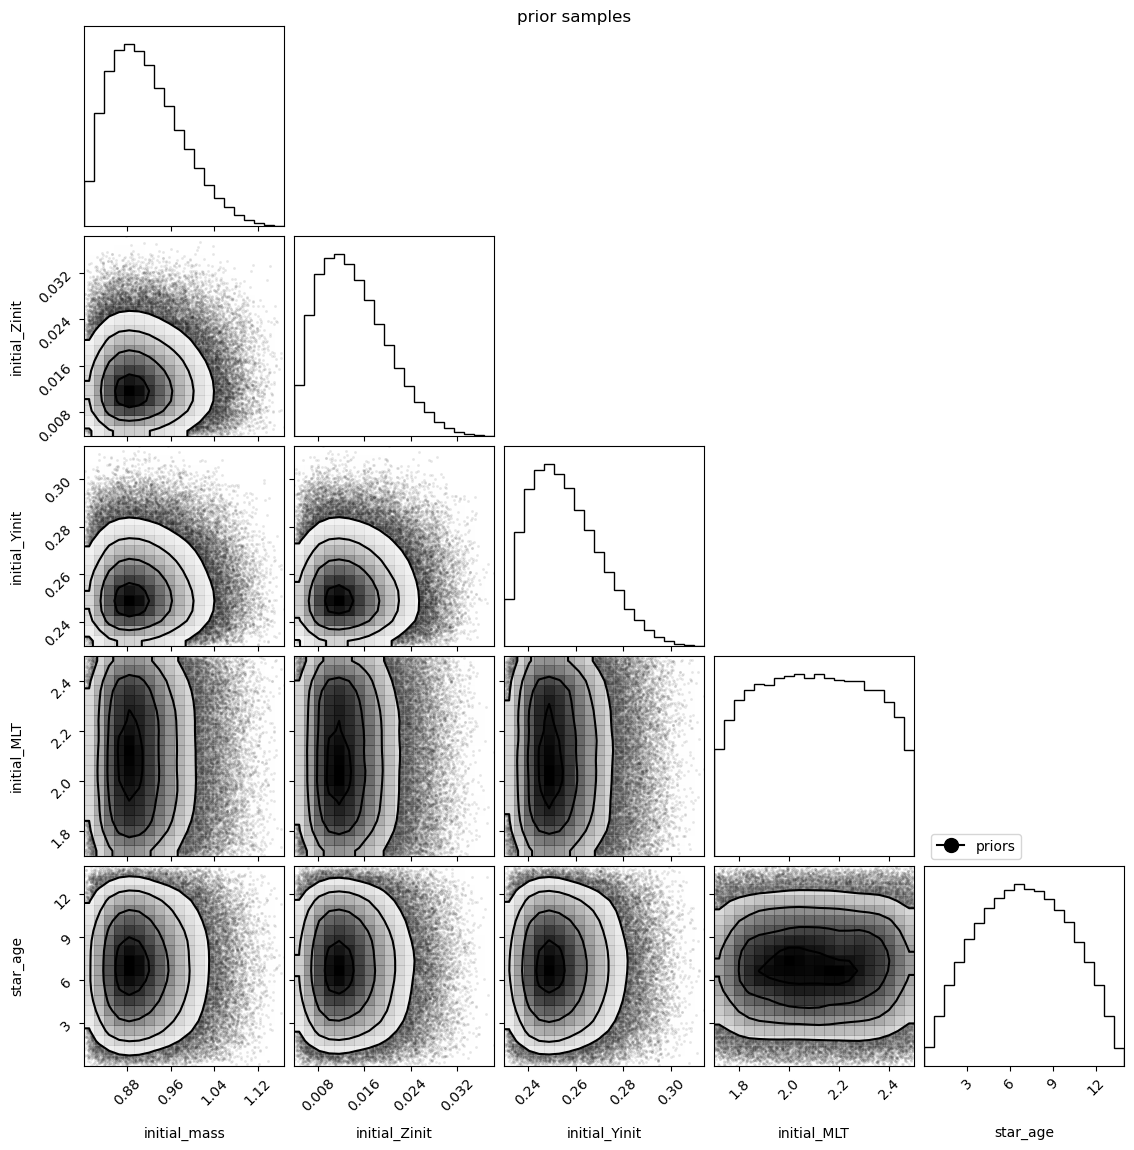

In [3]:
labels = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']

mass_prior = prior_funcs.custom_beta_prior(0.8, 1.2, a=2, b=5)

Zinit_prior = prior_funcs.custom_beta_prior(0.0038, 0.04, a=2, b=5)

Yinit_prior = prior_funcs.custom_beta_prior(0.23, 0.32, a=2, b=5)

MLT_prior = prior_funcs.custom_beta_prior(1.7, 2.5, a=1.2, b=1.2)

age_prior = prior_funcs.custom_beta_prior(0, 14, a=2, b=2)


priors = [mass_prior, Zinit_prior, Yinit_prior, MLT_prior, age_prior]

size = 100000
plot_prior_samples = np.array([prior.rvs(size=size) for prior in priors])
legend_labels = []
corner_color = 'black'
corner.corner(plot_prior_samples.T, labels = labels, color=corner_color, hist_kwargs={'density':True}, smooth=True);
legend_labels = legend_labels + [Line2D([0], [0], marker='o', color =corner_color, markerfacecolor = corner_color, markersize=10, label='priors')]
plt.suptitle('prior samples')
plt.legend(handles=legend_labels, bbox_to_anchor=(0., 1.0, 1., .0), loc=0)
plt.show()

In [4]:
%%time

with open("pitchfork/emulator_cov.pkl", 'rb') as fp:
     sigma_nn = pickle.load(fp)

ndraw_min=2**18
ndraw_max=2**19

obs_idx = 1
for hare_idx in range(100):
    path = f'form/hare{hare_idx}/obs{obs_idx}/'
    hare_observed = pd.read_json(path+f'obs{obs_idx}.json')
    hare_uncs = pd.read_json(path+'uncs.json')
    hare_uncs_array = hare_uncs.values[0]

    n_min = int(hare_uncs.drop(['calc_effective_T', 'luminosity', 'star_feh'], axis=1).columns[0].replace('nu_0_',''))
    n_max = int(hare_uncs.drop(['calc_effective_T', 'luminosity', 'star_feh'], axis=1).columns[-1].replace('nu_0_',''))

    sigma_nn_mask = np.zeros(len(sigma_nn), dtype=bool)
    sigma_nn_mask[:3] = True
    sigma_nn_mask[n_min-3:n_max-2] = True

    sigma_nn_cropped = sigma_nn[:,sigma_nn_mask][sigma_nn_mask,:]

    sigma_obs = (hare_uncs_array*hare_uncs_array)*(np.identity(len(hare_uncs_array)))

    sigma = sigma_nn_cropped + sigma_obs

    sigma_inv = np.linalg.inv(sigma)

    _, log_sigma_det = np.linalg.slogdet(sigma)
    
    outputs = ['calc_effective_T', 'luminosity', 'star_feh'] + [f'nu_0_{i}' for i in range(n_min,n_max+1)]
    
    sampler = ultra_ns_vector_nice(priors=priors, observed_vals=hare_observed[outputs].values[0], pitchfork=pitchfork,log_sigma_det=log_sigma_det, sigma_inv=sigma_inv, n_min=n_min, n_max=n_max, logl_scale=1)
    results = sampler(ndraw_min, ndraw_max).run(min_num_live_points=400, frac_remain=.05)
    with open(path+'/samples.pkl', 'wb') as fp:
        pickle.dump(results, fp, protocol=pickle.HIGHEST_PROTOCOL)

    sampler.cleanup()
    del results

[ultranest] Sampling 400 live points from prior ...


2024-06-17 17:09:49.437789: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


/home/oxs235/miniconda3/envs/pitchfork/lib/python3.9/site-packages/ultranest/integrator.py:1808: UserWarning: Sampling from region seems inefficient (0/262144 accepted in iteration 21). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)


[ultranest] Explored until L=-9  42 [-9.8318..-9.8303]*| it/evals=5964/1289496 eff=0.3996% N=400  0 
[ultranest] Likelihood function evaluations: 1289496
[ultranest]   logZ = -21.63 +- 0.1219
[ultranest] Effective samples strategy satisfied (ESS = 2042.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.12 tail:0.05 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-17.7500..-17.7498]*| it/evals=5282/838268 eff=0.6304% N=400     0    0 0  
[ultranest] Likelihood function evaluations: 838444
[ultranest]   logZ = -27.82 +- 0.1084
[ultranest] Effective samples strategy satisfied (ESS = 1888.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.05 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


/home/oxs235/miniconda3/envs/pitchfork/lib/python3.9/site-packages/ultranest/integrator.py:1808: UserWarning: Sampling from region seems inefficient (0/262144 accepted in iteration 21). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)


[ultranest] Explored until L=-1e+01   [-13.8845..-13.8836]*| it/evals=7996/3966804 eff=0.0108% N=400 
[ultranest] Likelihood function evaluations: 3966804
[ultranest]   logZ = -30.74 +- 0.1109
[ultranest] Effective samples strategy satisfied (ESS = 2044.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.20 bs:0.11 tail:0.05 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


/home/oxs235/miniconda3/envs/pitchfork/lib/python3.9/site-packages/ultranest/integrator.py:1808: UserWarning: Sampling from region seems inefficient (0/524288 accepted in iteration 21). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)


[ultranest] Explored until L=-1e+01   [-16.3651..-16.3643]*| it/evals=6711/2670277 eff=0.1743% N=400 
[ultranest] Likelihood function evaluations: 2670277
[ultranest]   logZ = -29.79 +- 0.1559
[ultranest] Effective samples strategy satisfied (ESS = 2570.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.16 tail:0.05 total:0.16 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


/home/oxs235/miniconda3/envs/pitchfork/lib/python3.9/site-packages/ultranest/integrator.py:1808: UserWarning: Sampling from region seems inefficient (0/262144 accepted in iteration 21). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)


[ultranest] Explored until L=-1e+01   [-13.2720..-13.2719]*| it/evals=5856/1269579 eff=1.8797% N=400 
[ultranest] Likelihood function evaluations: 1269579
[ultranest]   logZ = -24.81 +- 0.09845
[ultranest] Effective samples strategy satisfied (ESS = 2000.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.10 tail:0.05 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


/home/oxs235/miniconda3/envs/pitchfork/lib/python3.9/site-packages/ultranest/integrator.py:1808: UserWarning: Sampling from region seems inefficient (3/262144 accepted in iteration 21). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)


[ultranest] Explored until L=-8  45 [-9.0156..-9.0155]*| it/evals=5666/846420 eff=0.6697% N=400 
[ultranest] Likelihood function evaluations: 846420
[ultranest]   logZ = -20.03 +- 0.1069
[ultranest] Effective samples strategy satisfied (ESS = 1996.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.05 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


/home/oxs235/miniconda3/envs/pitchfork/lib/python3.9/site-packages/ultranest/integrator.py:1808: UserWarning: Sampling from region seems inefficient (0/524288 accepted in iteration 21). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)


[ultranest] Explored until L=-9  .39 [-10.1523..-10.1515]*| it/evals=6492/2924848 eff=0.8946% N=400 
[ultranest] Likelihood function evaluations: 2924848
[ultranest]   logZ = -23.15 +- 0.09867
[ultranest] Effective samples strategy satisfied (ESS = 2124.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.10 tail:0.05 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-18.6323..-18.6314]*| it/evals=5306/1058781 eff=0.5013% N=400    0 0    0 
[ultranest] Likelihood function evaluations: 1059111
[ultranest]   logZ = -28.75 +- 0.1071
[ultranest] Effective samples strategy satisfied (ESS = 1979.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.05 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


/home/oxs235/miniconda3/envs/pitchfork/lib/python3.9/site-packages/ultranest/integrator.py:1808: UserWarning: Sampling from region seems inefficient (0/262144 accepted in iteration 21). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)


[ultranest] Explored until L=-2e+01   [-19.5010..-19.5004]*| it/evals=5500/1202434 eff=0.4576% N=400 
[ultranest] Likelihood function evaluations: 1202537
[ultranest]   logZ = -29.99 +- 0.1192
[ultranest] Effective samples strategy satisfied (ESS = 2056.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.12 tail:0.05 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


/home/oxs235/miniconda3/envs/pitchfork/lib/python3.9/site-packages/ultranest/integrator.py:1808: UserWarning: Sampling from region seems inefficient (0/262144 accepted in iteration 21). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)


[ultranest] Explored until L=-1e+01   [-11.9506..-11.9495]*| it/evals=5995/617053 eff=1.2891% N=400 
[ultranest] Likelihood function evaluations: 617053
[ultranest]   logZ = -23.81 +- 0.1299
[ultranest] Effective samples strategy satisfied (ESS = 1983.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.13 tail:0.05 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


/home/oxs235/miniconda3/envs/pitchfork/lib/python3.9/site-packages/ultranest/integrator.py:1808: UserWarning: Sampling from region seems inefficient (0/262144 accepted in iteration 21). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)


[ultranest] Explored until L=-2e+01   [-19.3152..-19.3147]*| it/evals=5692/974044 eff=0.5846% N=400 
[ultranest] Likelihood function evaluations: 974044
[ultranest]   logZ = -30.42 +- 0.1086
[ultranest] Effective samples strategy satisfied (ESS = 1984.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.05 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


/home/oxs235/miniconda3/envs/pitchfork/lib/python3.9/site-packages/ultranest/integrator.py:1808: UserWarning: Sampling from region seems inefficient (0/262144 accepted in iteration 21). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)


[ultranest] Explored until L=-1e+01   [-10.9265..-10.9263]*| it/evals=6004/754139 eff=2.0548% N=400 
[ultranest] Likelihood function evaluations: 754139
[ultranest]   logZ = -22.81 +- 0.1276
[ultranest] Effective samples strategy satisfied (ESS = 2058.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.13 tail:0.05 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-14.2728..-14.2719]*| it/evals=5531/1883776 eff=0.2937% N=400 0  00  0  0  
[ultranest] Likelihood function evaluations: 1883776
[ultranest]   logZ = -24.87 +- 0.1177
[ultranest] Effective samples strategy satisfied (ESS = 1944.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.12 tail:0.05 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-11.1945..-11.1940]*| it/evals=5202/769259 eff=0.6766% N=400 0   0      0 
[ultranest] Likelihood function evaluations: 769259
[ultranest]   logZ = -21.09 +- 0.1171
[ultranest] Effective samples strategy satisfied (ESS = 1902.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.12 tail:0.05 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


/home/oxs235/miniconda3/envs/pitchfork/lib/python3.9/site-packages/ultranest/integrator.py:1808: UserWarning: Sampling from region seems inefficient (0/262144 accepted in iteration 21). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)


[ultranest] Explored until L=-1e+01   [-13.3822..-13.3822]*| it/evals=5559/1190633 eff=0.4671% N=400 
[ultranest] Likelihood function evaluations: 1190633
[ultranest]   logZ = -24.16 +- 0.1182
[ultranest] Effective samples strategy satisfied (ESS = 2065.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.12 tail:0.05 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


/home/oxs235/miniconda3/envs/pitchfork/lib/python3.9/site-packages/ultranest/integrator.py:1808: UserWarning: Sampling from region seems inefficient (0/262144 accepted in iteration 21). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)


[ultranest] Explored until L=-1e+01   [-11.6182..-11.6166]*| it/evals=7595/2174424 eff=0.7592% N=400  
[ultranest] Likelihood function evaluations: 2174424
[ultranest]   logZ = -27.51 +- 0.1393
[ultranest] Effective samples strategy satisfied (ESS = 2344.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.14 tail:0.05 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-11.4913..-11.4907]*| it/evals=5423/737300 eff=0.7359% N=400  0  0 0    0 
[ultranest] Likelihood function evaluations: 737397
[ultranest]   logZ = -21.95 +- 0.1207
[ultranest] Effective samples strategy satisfied (ESS = 1917.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.12 tail:0.05 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


/home/oxs235/miniconda3/envs/pitchfork/lib/python3.9/site-packages/ultranest/integrator.py:1808: UserWarning: Sampling from region seems inefficient (0/262144 accepted in iteration 21). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)


[ultranest] Explored until L=-2e+01   [-21.2459..-21.2451]*| it/evals=6855/4128167 eff=0.0280% N=400 
[ultranest] Likelihood function evaluations: 4128167
[ultranest]   logZ = -35.18 +- 0.1386
[ultranest] Effective samples strategy satisfied (ESS = 2322.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.14 tail:0.05 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


/home/oxs235/miniconda3/envs/pitchfork/lib/python3.9/site-packages/ultranest/integrator.py:1808: UserWarning: Sampling from region seems inefficient (0/262144 accepted in iteration 21). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)


[ultranest] Explored until L=-9  25 [-9.5843..-9.5840]*| it/evals=5716/1022844 eff=0.5591% N=400 
[ultranest] Likelihood function evaluations: 1023047
[ultranest]   logZ = -20.74 +- 0.1378
[ultranest] Effective samples strategy satisfied (ESS = 1948.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.14 tail:0.05 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


/home/oxs235/miniconda3/envs/pitchfork/lib/python3.9/site-packages/ultranest/integrator.py:1808: UserWarning: Sampling from region seems inefficient (0/262144 accepted in iteration 21). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)


[ultranest] Explored until L=-1e+01   [-11.0197..-11.0196]*| it/evals=5812/1201795 eff=1.6026% N=400 
[ultranest] Likelihood function evaluations: 1201806
[ultranest]   logZ = -22.36 +- 0.1144
[ultranest] Effective samples strategy satisfied (ESS = 2018.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.11 tail:0.05 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-12.4176..-12.4172]*| it/evals=5431/928830 eff=0.5850% N=400  0  0      0 
[ultranest] Likelihood function evaluations: 929131
[ultranest]   logZ = -22.8 +- 0.1178
[ultranest] Effective samples strategy satisfied (ESS = 2028.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.12 tail:0.05 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


/home/oxs235/miniconda3/envs/pitchfork/lib/python3.9/site-packages/ultranest/integrator.py:1808: UserWarning: Sampling from region seems inefficient (0/262144 accepted in iteration 21). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)


[ultranest] Explored until L=-1e+01   [-12.0172..-12.0171]*| it/evals=7784/1182372 eff=1.0951% N=400  
[ultranest] Likelihood function evaluations: 1182372
[ultranest]   logZ = -28.34 +- 0.1645
[ultranest] Effective samples strategy satisfied (ESS = 2233.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.17, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.16 tail:0.05 total:0.17 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


/home/oxs235/miniconda3/envs/pitchfork/lib/python3.9/site-packages/ultranest/integrator.py:1808: UserWarning: Sampling from region seems inefficient (0/524288 accepted in iteration 21). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)


[ultranest] Explored until L=-1e+01   [-12.7170..-12.7167]*| it/evals=6789/2595272 eff=0.1143% N=400 
[ultranest] Likelihood function evaluations: 2595272
[ultranest]   logZ = -26.63 +- 0.1185
[ultranest] Effective samples strategy satisfied (ESS = 1930.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.12 tail:0.05 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


/home/oxs235/miniconda3/envs/pitchfork/lib/python3.9/site-packages/ultranest/integrator.py:1808: UserWarning: Sampling from region seems inefficient (0/281438 accepted in iteration 21). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)


[ultranest] Explored until L=-1e+01   [-12.3382..-12.3372]*| it/evals=7534/2342119 eff=1.5501% N=400 00 
[ultranest] Likelihood function evaluations: 2342119
[ultranest]   logZ = -28.04 +- 0.1245
[ultranest] Effective samples strategy satisfied (ESS = 2241.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.12 tail:0.05 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


/home/oxs235/miniconda3/envs/pitchfork/lib/python3.9/site-packages/ultranest/integrator.py:1808: UserWarning: Sampling from region seems inefficient (0/524288 accepted in iteration 21). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)


[ultranest] Explored until L=-1e+01   [-15.0905..-15.0898]*| it/evals=7079/3692310 eff=0.0971% N=400 
[ultranest] Likelihood function evaluations: 3692310
[ultranest]   logZ = -29.63 +- 0.1682
[ultranest] Effective samples strategy satisfied (ESS = 1916.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.18, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.17 tail:0.05 total:0.18 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-13.5789..-13.5788]*| it/evals=5132/710888 eff=0.7223% N=400     0 0    0 
[ultranest] Likelihood function evaluations: 711121
[ultranest]   logZ = -23.33 +- 0.1128
[ultranest] Effective samples strategy satisfied (ESS = 1840.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.05 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


/home/oxs235/miniconda3/envs/pitchfork/lib/python3.9/site-packages/ultranest/integrator.py:1808: UserWarning: Sampling from region seems inefficient (1/262144 accepted in iteration 21). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)


[ultranest] Explored until L=-2e+01   [-17.1822..-17.1817]*| it/evals=6299/1406072 eff=0.2111% N=400 
[ultranest] Likelihood function evaluations: 1406072
[ultranest]   logZ = -29.66 +- 0.1263
[ultranest] Effective samples strategy satisfied (ESS = 2328.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.13 tail:0.05 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-19.7534..-19.7531]*| it/evals=5870/960692 eff=0.4527% N=400 0   0   0  0  
[ultranest] Likelihood function evaluations: 960692
[ultranest]   logZ = -31.27 +- 0.113
[ultranest] Effective samples strategy satisfied (ESS = 1962.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.11 tail:0.05 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-20.4035..-20.4034]*| it/evals=5113/682541 eff=0.7496% N=400     0   0  00 
[ultranest] Likelihood function evaluations: 682541
[ultranest]   logZ = -29.99 +- 0.1164
[ultranest] Effective samples strategy satisfied (ESS = 1824.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.14 bs:0.12 tail:0.05 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-9  05 [-9.5501..-9.5499]*| it/evals=5741/1475683 eff=0.2307% N=400        0      0 
[ultranest] Likelihood function evaluations: 1475683
[ultranest]   logZ = -20.75 +- 0.1286
[ultranest] Effective samples strategy satisfied (ESS = 2038.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.13 tail:0.05 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


/home/oxs235/miniconda3/envs/pitchfork/lib/python3.9/site-packages/ultranest/integrator.py:1808: UserWarning: Sampling from region seems inefficient (0/262144 accepted in iteration 21). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)


[ultranest] Explored until L=-2e+01   [-17.2250..-17.2245]*| it/evals=6742/1859769 eff=0.6221% N=400 
[ultranest] Likelihood function evaluations: 1859769
[ultranest]   logZ = -30.87 +- 0.1156
[ultranest] Effective samples strategy satisfied (ESS = 2157.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.12 tail:0.05 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


/home/oxs235/miniconda3/envs/pitchfork/lib/python3.9/site-packages/ultranest/integrator.py:1808: UserWarning: Sampling from region seems inefficient (1/262144 accepted in iteration 21). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)


[ultranest] Explored until L=-6  01 [-6.5267..-6.5264]*| it/evals=6492/2494016 eff=0.2976% N=400 
[ultranest] Likelihood function evaluations: 2494027
[ultranest]   logZ = -19.6 +- 0.1155
[ultranest] Effective samples strategy satisfied (ESS = 2062.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.12 tail:0.05 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01  [-10.1657..-10.1656]*| it/evals=5637/921285 eff=0.1618% N=400      00     0 
[ultranest] Likelihood function evaluations: 921285
[ultranest]   logZ = -21.13 +- 0.1278
[ultranest] Effective samples strategy satisfied (ESS = 2094.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.13 tail:0.05 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


/home/oxs235/miniconda3/envs/pitchfork/lib/python3.9/site-packages/ultranest/integrator.py:1808: UserWarning: Sampling from region seems inefficient (1/262144 accepted in iteration 21). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)


[ultranest] Explored until L=-1e+01   [-11.3366..-11.3334]*| it/evals=6545/1360256 eff=0.7673% N=400 
[ultranest] Likelihood function evaluations: 1360256
[ultranest]   logZ = -24.43 +- 0.1138
[ultranest] Effective samples strategy satisfied (ESS = 2440.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.11 tail:0.05 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


/home/oxs235/miniconda3/envs/pitchfork/lib/python3.9/site-packages/ultranest/integrator.py:1808: UserWarning: Sampling from region seems inefficient (0/262144 accepted in iteration 21). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)


[ultranest] Explored until L=-1e+01   [-15.1523..-15.1518]*| it/evals=6149/1898739 eff=0.2566% N=400 
[ultranest] Likelihood function evaluations: 1898739
[ultranest]   logZ = -27.33 +- 0.1159
[ultranest] Effective samples strategy satisfied (ESS = 2215.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.12 tail:0.05 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


/home/oxs235/miniconda3/envs/pitchfork/lib/python3.9/site-packages/ultranest/integrator.py:1808: UserWarning: Sampling from region seems inefficient (0/262144 accepted in iteration 21). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)


[ultranest] Explored until L=-2e+01   [-19.5046..-19.5042]*| it/evals=6918/2112080 eff=0.1732% N=400 
[ultranest] Likelihood function evaluations: 2112080
[ultranest]   logZ = -33.7 +- 0.1368
[ultranest] Effective samples strategy satisfied (ESS = 2087.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.14 tail:0.05 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-9  98 [-9.2693..-9.2683]*| it/evals=5838/1028790 eff=0.4073% N=400 0      0   0  0  
[ultranest] Likelihood function evaluations: 1028790
[ultranest]   logZ = -20.76 +- 0.111
[ultranest] Effective samples strategy satisfied (ESS = 1895.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.11 tail:0.05 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


/home/oxs235/miniconda3/envs/pitchfork/lib/python3.9/site-packages/ultranest/integrator.py:1808: UserWarning: Sampling from region seems inefficient (0/262144 accepted in iteration 21). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)


[ultranest] Explored until L=-1e+01   [-12.2557..-12.2556]*| it/evals=7070/1236058 eff=0.2035% N=400 
[ultranest] Likelihood function evaluations: 1236058
[ultranest]   logZ = -26.72 +- 0.1401
[ultranest] Effective samples strategy satisfied (ESS = 2288.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.14 tail:0.05 total:0.15 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


/home/oxs235/miniconda3/envs/pitchfork/lib/python3.9/site-packages/ultranest/integrator.py:1808: UserWarning: Sampling from region seems inefficient (0/262144 accepted in iteration 21). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)


[ultranest] Explored until L=-2e+01  
[ultranest] Likelihood function evaluations: 899433
[ultranest]   logZ = -31.35 +- 0.1235
[ultranest] Effective samples strategy satisfied (ESS = 2097.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.12 tail:0.05 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


/home/oxs235/miniconda3/envs/pitchfork/lib/python3.9/site-packages/ultranest/integrator.py:1808: UserWarning: Sampling from region seems inefficient (1/262144 accepted in iteration 21). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)


[ultranest] Explored until L=-7  16 [-7.5843..-7.5839]*| it/evals=7381/2017207 eff=0.8818% N=400  0 
[ultranest] Likelihood function evaluations: 2017207
[ultranest]   logZ = -22.88 +- 0.1698
[ultranest] Effective samples strategy satisfied (ESS = 2232.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.18, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.17 tail:0.05 total:0.18 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-15.2808..-15.2801]*| it/evals=5310/626225 eff=0.8485% N=400         0  0  
[ultranest] Likelihood function evaluations: 626419
[ultranest]   logZ = -25.41 +- 0.1226
[ultranest] Effective samples strategy satisfied (ESS = 1896.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.12 tail:0.05 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


/home/oxs235/miniconda3/envs/pitchfork/lib/python3.9/site-packages/ultranest/integrator.py:1808: UserWarning: Sampling from region seems inefficient (0/262144 accepted in iteration 21). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)


[ultranest] Explored until L=-1e+01   [-12.9888..-12.9886]*| it/evals=6022/737055 eff=0.4174% N=400 
[ultranest] Likelihood function evaluations: 737055
[ultranest]   logZ = -24.93 +- 0.1351
[ultranest] Effective samples strategy satisfied (ESS = 1925.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.14 tail:0.05 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-17.5164..-17.5162]*| it/evals=5292/775762 eff=0.6825% N=400 0 0 0      0 
[ultranest] Likelihood function evaluations: 775790
[ultranest]   logZ = -27.58 +- 0.1123
[ultranest] Effective samples strategy satisfied (ESS = 1980.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.05 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-25.4883..-25.4880]*| it/evals=5135/778083 eff=0.6603% N=400     0      0 00 0 
[ultranest] Likelihood function evaluations: 778083
[ultranest]   logZ = -35.22 +- 0.09326
[ultranest] Effective samples strategy satisfied (ESS = 1803.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.14 bs:0.09 tail:0.05 total:0.11 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


/home/oxs235/miniconda3/envs/pitchfork/lib/python3.9/site-packages/ultranest/integrator.py:1808: UserWarning: Sampling from region seems inefficient (0/262144 accepted in iteration 21). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)


[ultranest] Explored until L=-2e+01   [-16.5579..-16.5575]*| it/evals=5616/675918 eff=0.8314% N=400 
[ultranest] Likelihood function evaluations: 675918
[ultranest]   logZ = -27.48 +- 0.1113
[ultranest] Effective samples strategy satisfied (ESS = 1972.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.05 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


/home/oxs235/miniconda3/envs/pitchfork/lib/python3.9/site-packages/ultranest/integrator.py:1808: UserWarning: Sampling from region seems inefficient (0/262144 accepted in iteration 21). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)


[ultranest] Explored until L=-1e+01   [-13.2589..-13.2588]*| it/evals=5969/1013315 eff=0.6931% N=400 
[ultranest] Likelihood function evaluations: 1013315
[ultranest]   logZ = -25.06 +- 0.1125
[ultranest] Effective samples strategy satisfied (ESS = 2049.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.11 tail:0.05 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


/home/oxs235/miniconda3/envs/pitchfork/lib/python3.9/site-packages/ultranest/integrator.py:1808: UserWarning: Sampling from region seems inefficient (0/262144 accepted in iteration 21). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)


[ultranest] Explored until L=-6  43 [-6.8881..-6.8877]*| it/evals=5934/663156 eff=0.3328% N=400 
[ultranest] Likelihood function evaluations: 663156
[ultranest]   logZ = -18.6 +- 0.1118
[ultranest] Effective samples strategy satisfied (ESS = 1966.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.11 tail:0.05 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


/home/oxs235/miniconda3/envs/pitchfork/lib/python3.9/site-packages/ultranest/integrator.py:1808: UserWarning: Sampling from region seems inefficient (0/262144 accepted in iteration 21). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)


[ultranest] Explored until L=-2e+01   [-19.5055..-19.5055]*| it/evals=5849/752469 eff=0.2078% N=400 
[ultranest] Likelihood function evaluations: 752469
[ultranest]   logZ = -30.91 +- 0.127
[ultranest] Effective samples strategy satisfied (ESS = 1969.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.13 tail:0.05 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


/home/oxs235/miniconda3/envs/pitchfork/lib/python3.9/site-packages/ultranest/integrator.py:1808: UserWarning: Sampling from region seems inefficient (1/262144 accepted in iteration 21). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)


[ultranest] Explored until L=-2e+01   [-17.2640..-17.2636]*| it/evals=5938/1301878 eff=1.2371% N=400 
[ultranest] Likelihood function evaluations: 1301878
[ultranest]   logZ = -28.95 +- 0.08694
[ultranest] Effective samples strategy satisfied (ESS = 2002.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.09 tail:0.05 total:0.10 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


/home/oxs235/miniconda3/envs/pitchfork/lib/python3.9/site-packages/ultranest/integrator.py:1808: UserWarning: Sampling from region seems inefficient (0/262144 accepted in iteration 21). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)


[ultranest] Explored until L=-2e+01   [-20.4102..-20.4101]*| it/evals=6434/1804041 eff=0.1426% N=400 
[ultranest] Likelihood function evaluations: 1804041
[ultranest]   logZ = -33.27 +- 0.1328
[ultranest] Effective samples strategy satisfied (ESS = 2029.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.13 tail:0.05 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01  [-10.5139..-10.5125]*| it/evals=5671/852165 eff=0.6658% N=400      0   0 00 
[ultranest] Likelihood function evaluations: 852165
[ultranest]   logZ = -21.56 +- 0.1102
[ultranest] Effective samples strategy satisfied (ESS = 1948.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.05 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


/home/oxs235/miniconda3/envs/pitchfork/lib/python3.9/site-packages/ultranest/integrator.py:1808: UserWarning: Sampling from region seems inefficient (0/262144 accepted in iteration 21). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)


[ultranest] Explored until L=-1e+01   [-11.4363..-11.4361]*| it/evals=5640/1123400 eff=0.2260% N=400 
[ultranest] Likelihood function evaluations: 1123400
[ultranest]   logZ = -22.45 +- 0.1127
[ultranest] Effective samples strategy satisfied (ESS = 1902.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.11 tail:0.05 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-17.0469..-17.0464]*| it/evals=5740/1021505 eff=0.5621% N=400    0   0  0  
[ultranest] Likelihood function evaluations: 1021505
[ultranest]   logZ = -28.11 +- 0.1205
[ultranest] Effective samples strategy satisfied (ESS = 2259.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.12 tail:0.05 total:0.13 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-14.2583..-14.2579]*| it/evals=5091/590914 eff=0.8621% N=400     0   0  0  
[ultranest] Likelihood function evaluations: 590914
[ultranest]   logZ = -23.92 +- 0.112
[ultranest] Effective samples strategy satisfied (ESS = 1811.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.14 bs:0.11 tail:0.05 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


/home/oxs235/miniconda3/envs/pitchfork/lib/python3.9/site-packages/ultranest/integrator.py:1808: UserWarning: Sampling from region seems inefficient (0/262144 accepted in iteration 21). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)


[ultranest] Explored until L=-2e+01   [-16.9929..-16.9928]*| it/evals=5611/971462 eff=0.5051% N=400 
[ultranest] Likelihood function evaluations: 971462
[ultranest]   logZ = -27.83 +- 0.1297
[ultranest] Effective samples strategy satisfied (ESS = 1936.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.13 tail:0.05 total:0.14 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-17.3832..-17.3819]*| it/evals=5445/962852 eff=0.5657% N=400    00 0    0 
[ultranest] Likelihood function evaluations: 962852
[ultranest]   logZ = -27.76 +- 0.1138
[ultranest] Effective samples strategy satisfied (ESS = 2073.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.05 total:0.12 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 400 live points from prior ...


/home/oxs235/miniconda3/envs/pitchfork/lib/python3.9/site-packages/ultranest/integrator.py:1808: UserWarning: Sampling from region seems inefficient (0/262144 accepted in iteration 21). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)


Unexpected exception formatting exception. Falling back to standard exception954384 eff=0.0037% N=400 


Traceback (most recent call last):
  File "/home/oxs235/miniconda3/envs/pitchfork/lib/python3.9/site-packages/IPython/core/magics/execution.py", line 1340, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 34, in <module>
  File "/home/oxs235/miniconda3/envs/pitchfork/lib/python3.9/site-packages/ultranest/integrator.py", line 2373, in run
    for result in self.run_iter(
  File "/home/oxs235/miniconda3/envs/pitchfork/lib/python3.9/site-packages/ultranest/integrator.py", line 2645, in run_iter
    u, p, L = self._create_point(Lmin=Lmin, ndraw=ndraw, active_u=active_u, active_values=active_values)
  File "/home/oxs235/miniconda3/envs/pitchfork/lib/python3.9/site-packages/ultranest/integrator.py", line 1888, in _create_point
    u, v, logl, nc, quality = self._refill_samples(Lmin, ndraw, nit)
  File "/home/oxs235/miniconda3/envs/pitchfork/lib/python3.9/site-packages/ultranest/integrator.py", line 1774, in _refill_samples
    v = self.transform(u)
  File "/home/oxs235/repo